In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import pylab as plt
plt.style.use('fivethirtyeight')

# Read data

In [2]:
data = pd.read_csv('./data/EF_battles_corrected.csv', parse_dates=['start', 'end'])

In [3]:
data.shape

(133, 29)

In [4]:
data['end_num'] = (data['end'].dt.year -1938) * 12 +  data['end'].dt.month
data['start_num'] = (data['start'].dt.year -1938) * 12 +  data['start'].dt.month
data['duration'] = (data['end_num'] - data['start_num']).clip(lower=1)

In [5]:
data.shape

(133, 32)

### Data types and missing values

In [6]:
data.dtypes

name                                 object
url                                  object
allies killed                       float64
axis killed                         float64
allies_destroyed_tanks                int64
allies_destroyed_airplane             int64
allies_destroyed_guns                 int64
axis_destroyed_tanks                  int64
axis_destroyed_airplane               int64
axis_destroyed_guns                   int64
belligerents.allies                  object
belligerents.axis                    object
axis_leaders                         object
allies_leaders                       object
result_prop                         float64
result                               object
axis_planes                         float64
axis_guns                           float64
axis_tanks                          float64
axis_infantry                       float64
allies_planes                       float64
allies_guns                         float64
allies_tanks                    

In [7]:
cols = [
    'allies_infantry', 'axis_infantry',
    'allies_tanks', 'axis_tanks',
    'allies_guns', 'axis_guns'
]


In [8]:
mask = data[['allies_infantry', 'axis_infantry']].notnull().all(1)

In [9]:
data_kmeans = data.loc[mask, cols].fillna(0)

In [10]:
data_kmeans.shape

(84, 6)

In [11]:
data['result_num'] = data['result'].map({'axis':-1, 'allies':1}).fillna(0)  # 0 for tie

In [12]:
data['result_num'].value_counts()

-1.0    93
 1.0    34
 0.0     6
Name: result_num, dtype: int64

# 1. Unsupervised learning: K-means

In [13]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=5, random_state=2019)

In [14]:
labels = model.fit_predict(data_kmeans) + 1  # for naming

In [15]:
print(labels)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 4 4 1 1 3 1 1 3 1 1 1 1 1 1 5 1 3
 5 4 2 3 1 1 1 1 3 4 3 1 1 3 3 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 4 3 1 1 1
 1 1 1 3 3 4 1 1 2 1]


In [16]:
data_kmeans['label'] = ('Cluster ' + pd.Series((labels)).astype(str)).values
data_kmeans[['name', 'result', 'start']] = data.loc[mask, ['name', 'result', 'start']]

## Visualise

In [17]:
import altair as alt


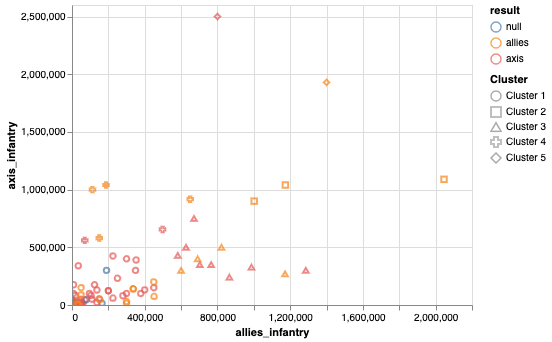

In [18]:
c = alt.Chart(data_kmeans).mark_point().encode(
    shape=alt.Shape('label:N', legend=alt.Legend(title='Cluster')),
    x='allies_infantry', y='axis_infantry', color='result',
    tooltip=data_kmeans.columns.tolist()).interactive()

c

# Scale

In [19]:
from sklearn.preprocessing import scale

In [20]:
data_to_scale = data_kmeans.drop(['label', 'name', 'start', 'result'], axis=1)
data_scaled = scale(data_to_scale)

In [21]:
labels_scaled = model.fit_predict(data_scaled) + 1

In [22]:
# data_scaled['label'] = ('Cluster ' + pd.Series((labels_scaled +1)).astype(str)).values
# data_scaled[['name', 'result', 'start']] = data.loc[~mask, ['name', 'result', 'start']]

data_kmeans['label 2'] = ('Cluster ' + pd.Series((labels_scaled)).astype(str)).values

In [24]:
c.data = data_kmeans

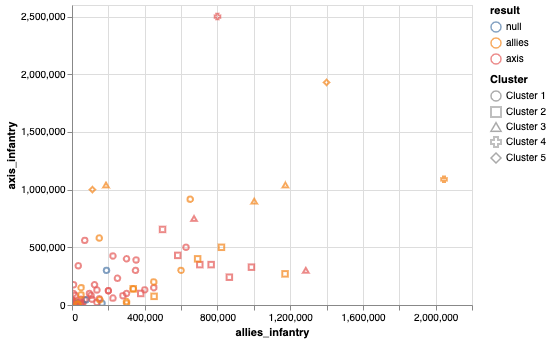

In [25]:
c.encode(shape=alt.Shape('label 2:N', legend=alt.Legend(title='Cluster')))

In [23]:
centroids = pd.DataFrame(model.cluster_centers_, columns=data_to_scale.columns)
centroids.index +=1

In [26]:
centroids

,allies_infantry,axis_infantry,allies_tanks,axis_tanks,allies_guns,axis_guns
1,-0.425934,-0.337092,-0.395420,-0.342418,-0.368492,-0.300108
2,0.971306,0.125042,0.972274,0.694377,0.588149,0.244765
3,1.427259,1.304877,2.135124,1.154229,3.128675,1.355008
4,2.872654,3.703101,-0.560908,-0.596190,-0.453108,-0.380866
5,1.148299,2.902859,1.845183,4.330537,0.710037,4.978168
